## PROJECT TITLE: GLOBAL ENERGY TRENDS

### AUTHORS:
- Pamela Angulo Martinez
- Santhosh Adavala
- Akhila Myaka
- Devashree Kiran Pawar

In [1]:
# Load the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry_convert as pc
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("Data/owid-energy-data.csv") 
print(df.columns)

Index(['country', 'year', 'iso_code', 'population', 'gdp',
       'biofuel_cons_change_pct', 'biofuel_cons_change_twh',
       'biofuel_cons_per_capita', 'biofuel_consumption',
       'biofuel_elec_per_capita',
       ...
       'solar_share_elec', 'solar_share_energy', 'wind_cons_change_pct',
       'wind_cons_change_twh', 'wind_consumption', 'wind_elec_per_capita',
       'wind_electricity', 'wind_energy_per_capita', 'wind_share_elec',
       'wind_share_energy'],
      dtype='object', length=129)


### Question 1 : How have global renewable energy shares changed over the last two decades, and what trends can be detected across continents? 

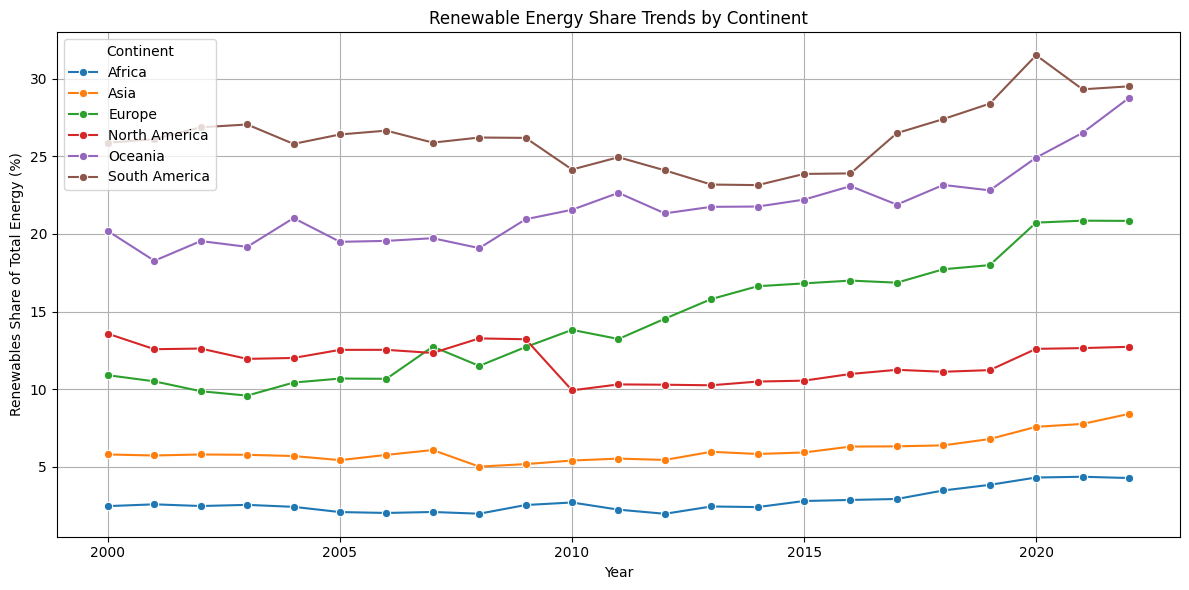

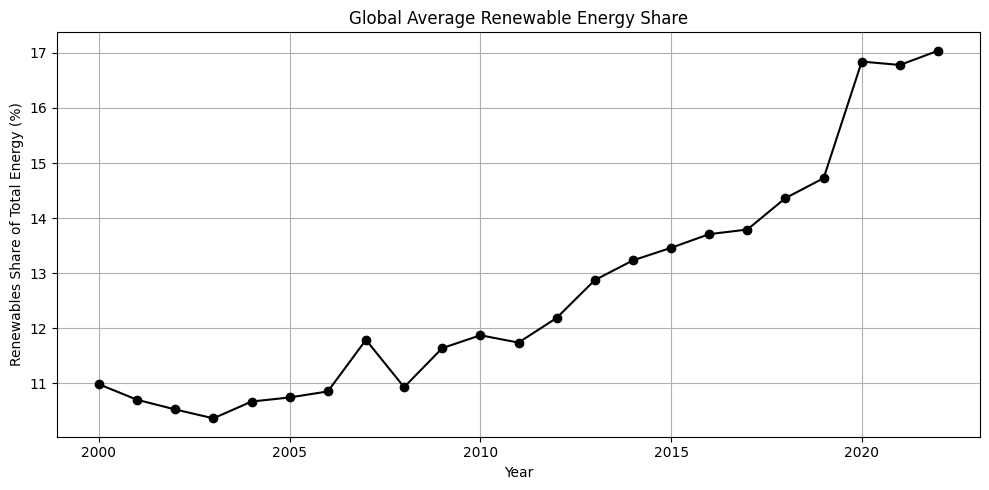

In [3]:
# Create df_q1 with selected columns and clean data
df_q1 = df[['country', 'iso_code', 'year', 'renewables_share_energy']].copy()
df_q1 = df_q1[df_q1['year'] >= 2000].dropna(subset=['renewables_share_energy', 'iso_code'])

# Compute global average trend
global_trend = df_q1.groupby("year")["renewables_share_energy"].mean().reset_index()

# Map ISO codes to continents
def map_country_to_continent(iso_code):
    try:
        country_alpha2 = pc.country_alpha3_to_country_alpha2(iso_code)
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return None

df_q1["continent"] = df_q1["iso_code"].apply(map_country_to_continent)
df_q1 = df_q1.dropna(subset=["continent"])

# Compute continent-level trends
continent_trend = df_q1.groupby(["continent", "year"])["renewables_share_energy"].mean().reset_index()

# Plot continental trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=continent_trend, x="year", y="renewables_share_energy", hue="continent", marker="o")
plt.title("Renewable Energy Share Trends by Continent")
plt.xlabel("Year")
plt.ylabel("Renewables Share of Total Energy (%)")
plt.grid(True)
plt.legend(title="Continent")
plt.tight_layout()
plt.show()

# Plot global trend
plt.figure(figsize=(10, 5))
plt.plot(global_trend["year"], global_trend["renewables_share_energy"], marker='o', color='black')
plt.title("Global Average Renewable Energy Share")
plt.xlabel("Year")
plt.ylabel("Renewables Share of Total Energy (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


### Question 2 : How does economic growth impact the rate of renewable energy adoption across different continents?

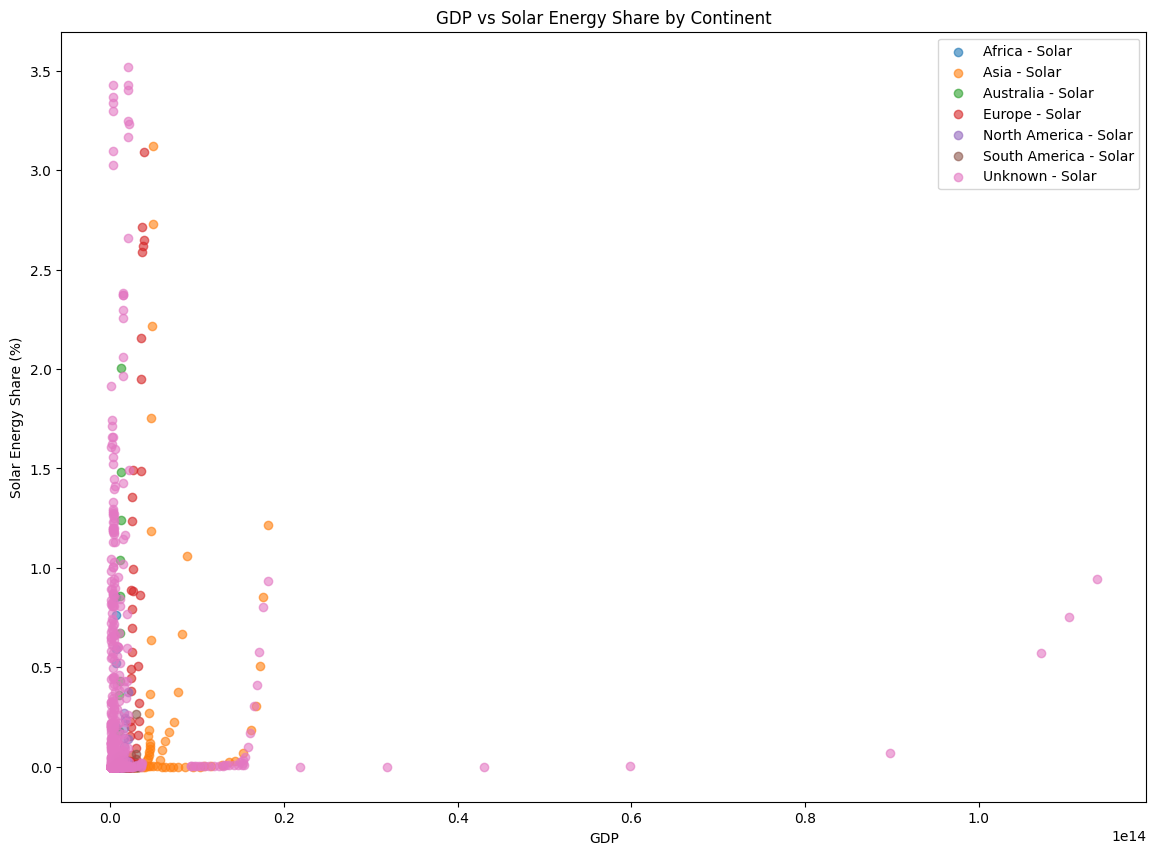

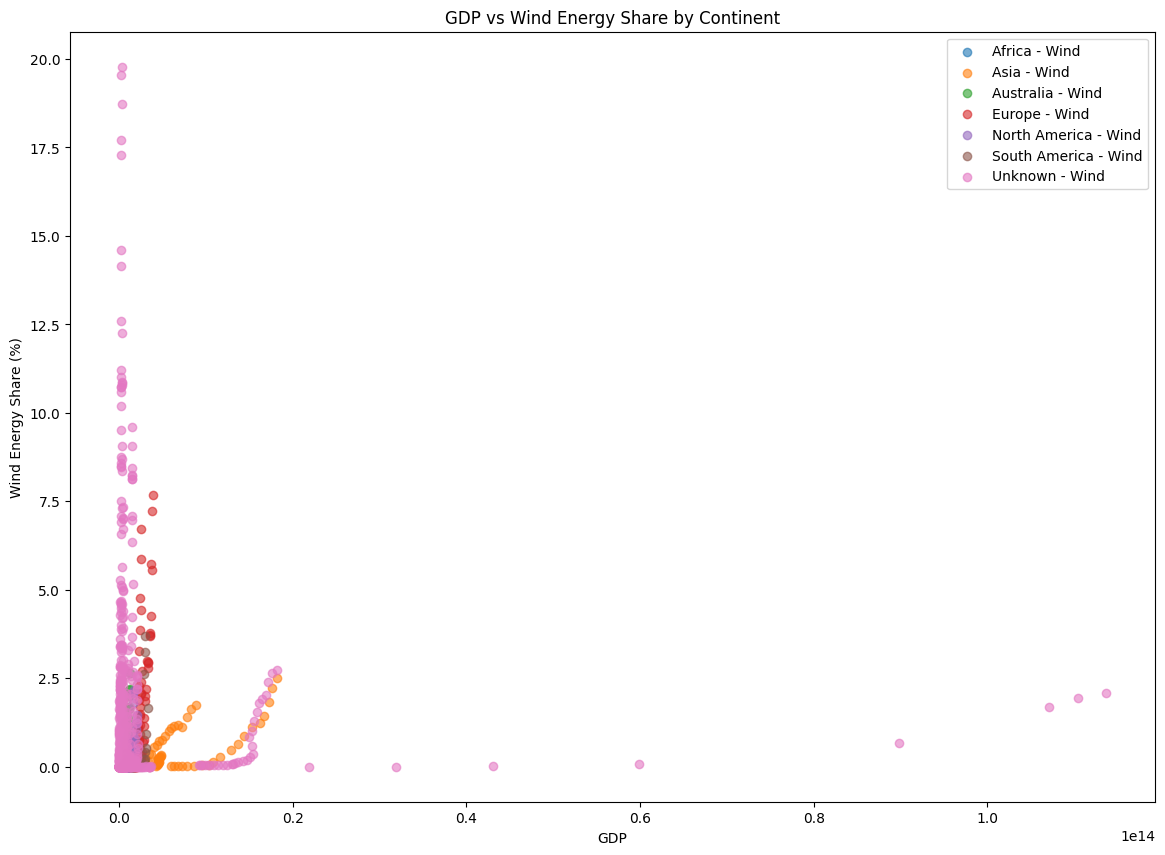

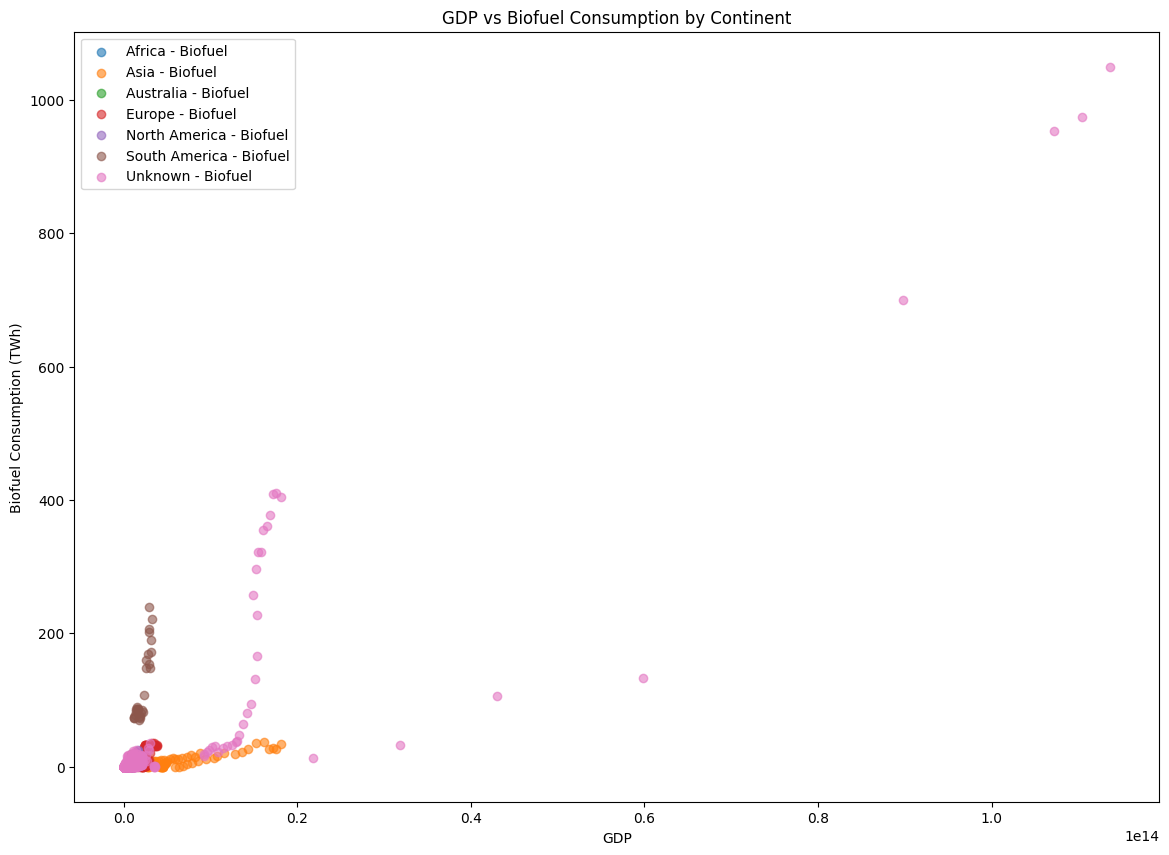

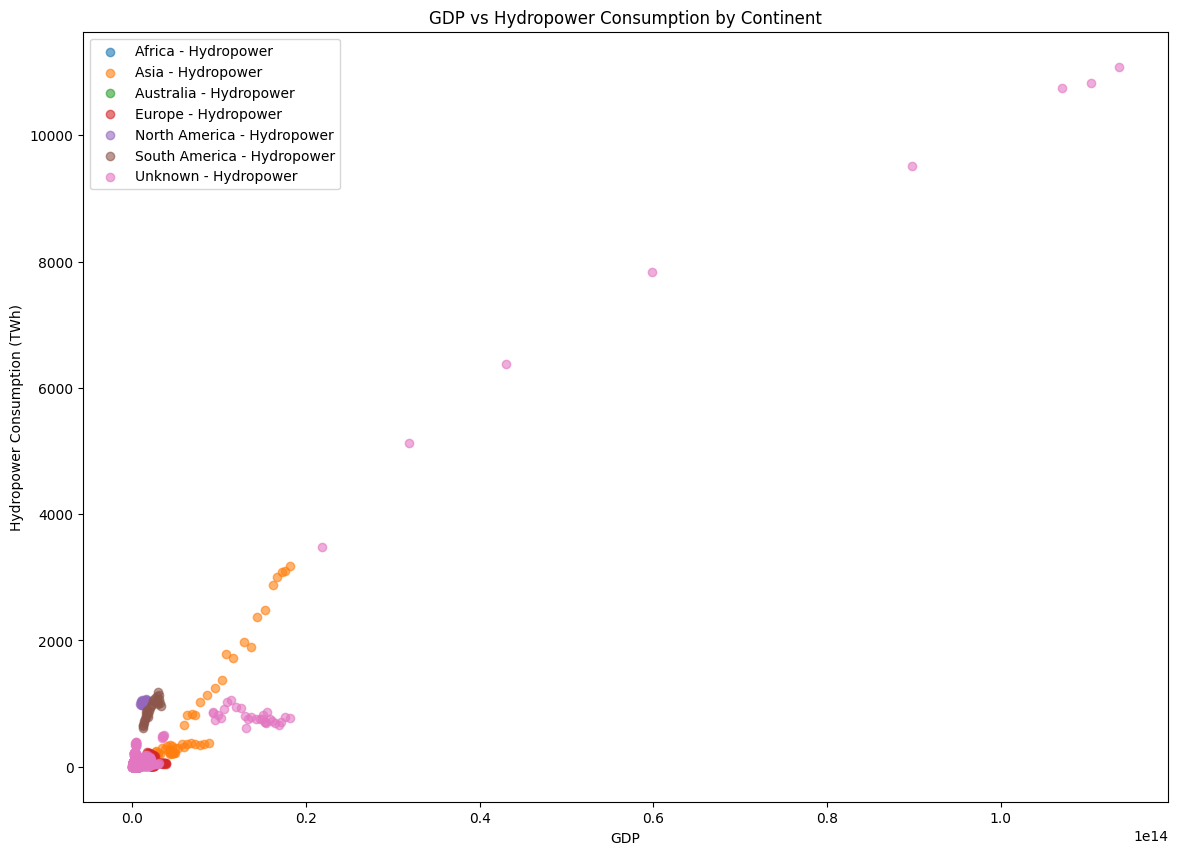

In [4]:
# Create df_q2 with selected columns and clean data
# Ensure all required columns exist in the dataframe
required_columns = ['country', 'year', 'gdp', 'solar_share_energy', 'wind_share_energy', 'hydro_consumption', 'biofuel_consumption']
missing_columns = [col for col in required_columns if col not in df.columns]

# Add missing columns with default values if necessary
for col in missing_columns:
    df[col] = 0  # Default value for missing columns

df_q2 = df[required_columns].copy()
df_q2 = df_q2.dropna()

# Dictionary to map countries to continents (expand if needed)
country_to_continent = {
    'USA': 'North America', 'Canada': 'North America', 'Mexico': 'North America',
    'Brazil': 'South America', 'Argentina': 'South America', 'Colombia': 'South America',
    'Germany': 'Europe', 'France': 'Europe', 'United Kingdom': 'Europe',
    'China': 'Asia', 'India': 'Asia', 'Japan': 'Asia',
    'Australia': 'Australia', 'South Africa': 'Africa', 'Nigeria': 'Africa',
    'ASEAN (Ember)': 'Asia',
}

# Function to map country to continent
def get_continent(country):
    return country_to_continent.get(country, 'Unknown')

# Map continents to df_q2
df_q2['continent'] = df_q2['country'].apply(get_continent)

# Group data by continent
continent_grouped = df_q2.groupby('continent')

# Plot for Solar Energy Share
plt.figure(figsize=(14, 10))
for continent_name, continent_data in continent_grouped:
    plt.scatter(continent_data['gdp'], continent_data['solar_share_energy'], label=f'{continent_name} - Solar', alpha=0.6)

plt.title('GDP vs Solar Energy Share by Continent')
plt.xlabel('GDP')
plt.ylabel('Solar Energy Share (%)')
plt.legend()
plt.show()

# Plot for Wind Energy Share
plt.figure(figsize=(14, 10))
for continent_name, continent_data in continent_grouped:
    plt.scatter(continent_data['gdp'], continent_data['wind_share_energy'], label=f'{continent_name} - Wind', alpha=0.6)

plt.title('GDP vs Wind Energy Share by Continent')
plt.xlabel('GDP')
plt.ylabel('Wind Energy Share (%)')
plt.legend()
plt.show()

# Plot for Biofuel Consumption
plt.figure(figsize=(14, 10))
for continent_name, continent_data in continent_grouped:
    plt.scatter(continent_data['gdp'], continent_data['biofuel_consumption'],
                label=f'{continent_name} - Biofuel', alpha=0.6)

plt.title('GDP vs Biofuel Consumption by Continent')
plt.xlabel('GDP')
plt.ylabel('Biofuel Consumption (TWh)')
plt.legend()
plt.show()

# Plot for Hydropower Consumption
plt.figure(figsize=(14, 10))
for continent_name, continent_data in continent_grouped:
    plt.scatter(continent_data['gdp'], continent_data['hydro_consumption'], label=f'{continent_name} - Hydropower', alpha=0.6)

plt.title('GDP vs Hydropower Consumption by Continent')
plt.xlabel('GDP')
plt.ylabel('Hydropower Consumption (TWh)')
plt.legend()
plt.show()


### Question 3 : How can countries be grouped based on their renewable and fossil fuel usage and what insights can be derived from these clusters?

In [5]:
# Define the feature columns related to different types of energy consumption
features = [
    'fossil_fuel_consumption',
    'hydro_consumption',
    'solar_consumption',
    'wind_consumption',
    'biofuel_consumption',
    'other_renewable_consumption',
    'renewables_consumption',
    'low_carbon_consumption'
]

# Select the feature columns from the dataframe and drop rows with missing values
X = df[features].dropna()

# Standardize the features (mean=0, variance=1) to prepare for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Assign the cluster labels back to the original dataframe
df.loc[X.index, 'cluster'] = clusters

# Calculate the cluster centers, inverse-transforming to original feature scale
centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=features
)

# Print the cluster centers to understand the typical profile of each cluster
print("Cluster Centers:")
print(centers, "\n")

# Print the number of countries (or records) assigned to each cluster
print("Counts per cluster:")
print(df['cluster'].value_counts(), "\n")

# Print a sample of 5 countries from each cluster to explore cluster composition
print("Sample countries in each cluster:")
for cl in sorted(df['cluster'].dropna().unique()):
    sample = df[df['cluster'] == cl]['country'].dropna().unique()[:5]
    print(f"Cluster {int(cl)}:", ", ".join(sample))


Cluster Centers:
   fossil_fuel_consumption  hydro_consumption  solar_consumption  \
0             38654.580856        2941.894709          76.982565   
1              3759.845630         295.202101           4.979083   
2             79918.448383        6299.949133         980.452550   

   wind_consumption  biofuel_consumption  other_renewable_consumption  \
0        272.928388           127.904458                   295.161990   
1         12.243255             9.355921                    21.278518   
2       1949.984033           556.345250                  1150.437683   

   renewables_consumption  low_carbon_consumption  
0             3714.872102             6210.907040  
1              343.058874              519.457851  
2            10937.168583            15297.559483   

Counts per cluster:
cluster
1.0    2122
0.0     402
2.0      60
Name: count, dtype: int64 

Sample countries in each cluster:
Cluster 0: Asia, Asia Pacific (EI), China, Europe, Europe (EI)
Cluster 1: Africa,